In [29]:
%load_ext autoreload
%autoreload 2

import numpy as np
import jax.numpy as jnp
import jax
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import seaborn as sns
import pickle
import copy

import rksd.metrics as metrics
import rksd.kernels as kernels
import rksd.exp_utils as exp_utils

plt.rcParams["mathtext.fontset"] = "cm"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load

In [30]:
n = 500
dim = 1
res_stats = pickle.load(open(f"../data/weight/stats_n{n}_d{dim}.pkl", "rb"))

b_ls = list(res_stats.keys())
print(b_ls)
ol = list(res_stats[b_ls[0]].keys())[0]
print(ol)
eps_ls = list(res_stats[b_ls[0]][ol].keys())
print(eps_ls)

[0.25, 0.5, 1.0]
10.0
[0.0, 0.01, 0.05, 0.075, 0.1, 0.125, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


In [31]:
eps_ls = eps_ls[:11]

In [52]:
plot_df_ls = {}

methods = {"tilted": "Tilted"}

plot_df = {"eps": [], "nonsq_stat": [], "method": [], "rej": [], "b": []}

for eps in eps_ls:
    rr = res_stats[b_ls[0]][ol][eps]["standard"]
    plot_df["nonsq_stat"].extend(np.array(rr["nonsq_stat"]).tolist())
    plot_df["eps"].extend([eps] * len(rr["nonsq_stat"]))
    plot_df["rej"].extend(rr["rej"])
    plot_df["b"].extend([rf"$b=0.$"] * len(rr["nonsq_stat"]))
    # plot_df["b"].extend([str(0.)] * len(rr["nonsq_stat"]))
    plot_df["method"].extend(["IMQ"] * len(rr["nonsq_stat"]))

for b in b_ls:
    for eps in eps_ls:
        for m, m_label in methods.items():
            rr = res_stats[b][ol][eps][m]
            plot_df["nonsq_stat"].extend(np.array(rr["nonsq_stat"]).tolist())
            plot_df["eps"].extend([eps] * len(rr["nonsq_stat"]))
            
            plot_df["rej"].extend(rr["rej"])
            plot_df["b"].extend([rf"$b={b}$"] * len(rr["nonsq_stat"]))
            # plot_df["b"].extend([str(b)] * len(rr["nonsq_stat"]))
            plot_df["method"].extend([m_label] * len(rr["nonsq_stat"]))

plot_df = pd.DataFrame(plot_df)

In [53]:
# stein kernel plot
X = jnp.reshape(jnp.linspace(-3., 3., 1001), (-1, 1))

ksd_vals_ls = []

score_fn = lambda x: -x

# IMQ
kernel = kernels.IMQ(sigma_sq=2*1.)
ksd_imq = metrics.KSD(kernel, score_fn=score_fn)

ksd_imq_vals = np.diagonal(ksd_imq(X, vstat=True, output_dim=2))
ksd_vals_ls.append(ksd_imq_vals)

# R-KSD boot
score = score_fn(X)

for b in b_ls:
    score_weight_fn = kernels.PolyWeightFunction(b=b)
    kernel0 = kernels.IMQ(sigma_sq=2*1.)
    kernel = kernels.TiltedKernel(kernel=kernel0, weight_fn=score_weight_fn)
    ksd_tilted = metrics.KSD(kernel)
    
    ksd_tilted_vals = np.diagonal(ksd_tilted(X, vstat=True, output_dim=2, score=score))
    ksd_vals_ls.append(ksd_tilted_vals)

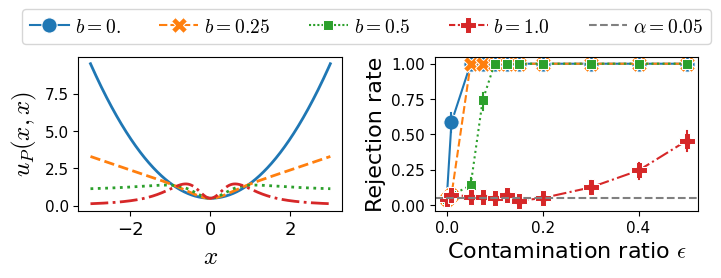

In [57]:
_, axes = plt.subplots(ncols=2, figsize=(8, 2))

# stein kernel
ax = axes[0]
linestyles = ["solid", "dashed", "dotted", "dashdot"]

for i, b in enumerate(plot_df.b.unique()):
    ksd_vals = ksd_vals_ls[i]
    ax.plot(np.reshape(X, -1), ksd_vals, label=rf"$b={b}$", linestyle=linestyles[i], linewidth=2)
ax.set_xlabel(r"$x$", fontsize=18)
ax.set_ylabel(r"$u_P(x, x)$", fontsize=18)
ax.tick_params(axis="both", labelsize=13)
ax.yaxis.set_tick_params(labelsize=11)

# rej probs
ax = axes[1]
_ = sns.lineplot(ax=ax, data=plot_df, x="eps", y="rej", hue="b", style="b", markers=True, err_style="bars", markersize=11)

ax.axhline(0.05, color="grey", linestyle="--", label=r"$\alpha=0.05$")
for i in range(len(plot_df.b.unique())):
    ax.lines[2*i].set_linestyle(linestyles[i])
ax.set_xlabel(r"Contamination ratio $\epsilon$", fontsize=16)
ax.set_ylabel("Rejection rate", fontsize=16)
ax.tick_params(axis="both", labelsize=11)
ax.legend([],[], frameon=False)

# ax.legend()
lgd = axes[1].legend(bbox_to_anchor=(-1.6, 1.02, 1, 0.2), loc="lower left", ncol=5, fontsize=14, handletextpad=0.3)
# lg = axes[1].legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=14)
# lg.set_title(r"$b$", prop={"size": 14})

plt.subplots_adjust(wspace=0.35)
plt.savefig("../figs/stein_kernels.pdf", bbox_extra_artists=(lgd,), bbox_inches="tight")